In [1]:
import pandas as pd
from statsbombpy import sb
import numpy as np
from mplsoccer import Pitch,VerticalPitch, Sbopen, FontManager, inset_image
import plotly.express as px

### Expected threat for any team or any player can be calculated
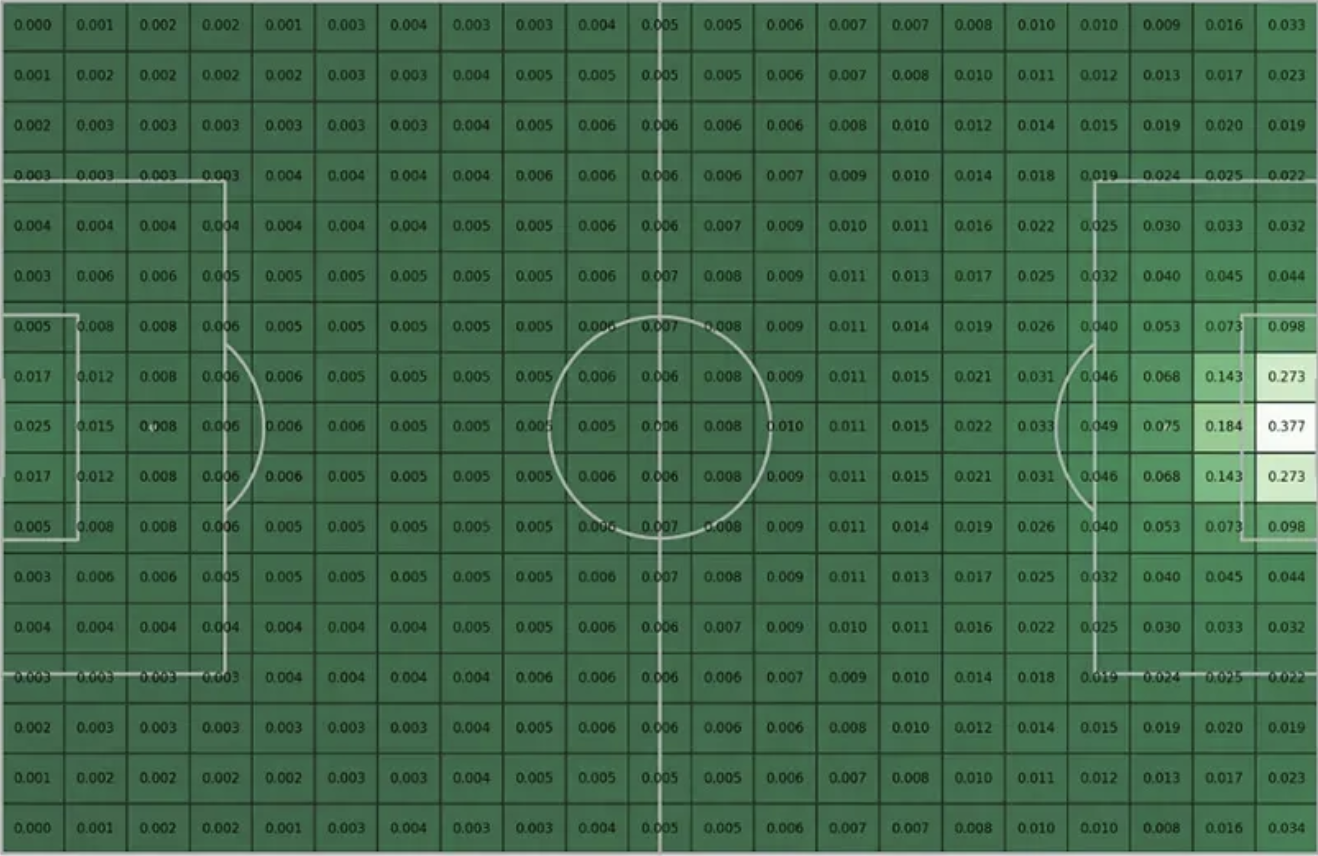
These are a set of values set by years and years of calculation
After calculating the threat from the grids shown in the above picture in a football field
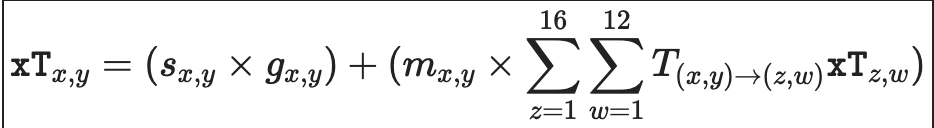
1. Move probability m x , y : when a player has possession in zone ( x , y ) , how often do they opt to move (i.e. pass or dribble) the ball as their next action? 
2. Shoot probability s x , y : when a player has possession in zone ( x , y ) , how often do they opt to shoot as their next action? In our simplified universe, players can only either move or shoot, so by definition m x , y + s x , y = 100 % . 
3. Move transition matrix T x , y : in the cases where the player moves from zone ( x , y ) , what is the probability that they move to each of the other zones? The visualization above shows these probabilities in shades of green.
4. Goal probability g x , y : in the cases where the player shoots from zone ( x , y ) , what is the probability that the shot turns into a goal? Note that this quantity is essentially a very simple implementation of xG!

Initially the Xt for all the parts of field is set to 0. After some iterations we will see that the grids will have certain values
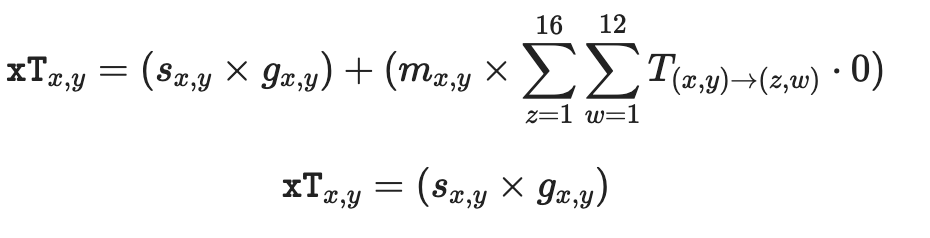


In [21]:
import pandas as pd
import numpy as np

# import data
df = pd.read_csv("europaFinal.csv")

# preprocess the dataframe so we only have the data we want
# We want to get it down to be only successful passes made by Bruno Penandes
# we can use pandas .loc method to achieve this with a bunch of & statements

df = df.loc[(df['teamId']=='Manchester United') & (df['playerId']==18) & (df['outcome']=='Successful') & (df['type']=='Pass')]

In [23]:
df.head()

,minute,second,teamId,x,y,period,type,outcome,playerId,endX,endY
2,0,0.0,Manchester United,49.9,50.0,FirstHalf,Pass,Successful,18.0,31.5,59.6
119,6,11.0,Manchester United,65.4,96.8,FirstHalf,Pass,Successful,18.0,63.3,87.8
130,6,55.0,Manchester United,69.8,30.3,FirstHalf,Pass,Successful,18.0,74.4,18.8
133,7,1.0,Manchester United,84.3,23.3,FirstHalf,Pass,Successful,18.0,86.0,20.0
185,12,20.0,Manchester United,39.0,64.8,FirstHalf,Pass,Successful,18.0,32.8,72.9


In [24]:
#Import xT Grid, turn it into an array, and then get how many rows and columns it has
xT = pd.read_csv("xT_grid.csv", header=None)
xT = np.array(xT)
xT_rows, xT_cols = xT.shape

In [25]:
xT # this is how our pitch is broken up

array([[0.00638303, 0.00779616, 0.00844854, 0.00977659, 0.01126267,
        0.01248344, 0.01473596, 0.0174506 , 0.02122129, 0.02756312,
        0.03485072, 0.0379259 ],
       [0.00750072, 0.00878589, 0.00942382, 0.0105949 , 0.01214719,
        0.0138454 , 0.01611813, 0.01870347, 0.02401521, 0.02953272,
        0.04066992, 0.04647721],
       [0.0088799 , 0.00977745, 0.01001304, 0.01110462, 0.01269174,
        0.01429128, 0.01685596, 0.01935132, 0.0241224 , 0.02855202,
        0.05491138, 0.06442595],
       [0.00941056, 0.01082722, 0.01016549, 0.01132376, 0.01262646,
        0.01484598, 0.01689528, 0.0199707 , 0.02385149, 0.03511326,
        0.10805102, 0.25745362],
       [0.00941056, 0.01082722, 0.01016549, 0.01132376, 0.01262646,
        0.01484598, 0.01689528, 0.0199707 , 0.02385149, 0.03511326,
        0.10805102, 0.25745362],
       [0.0088799 , 0.00977745, 0.01001304, 0.01110462, 0.01269174,
        0.01429128, 0.01685596, 0.01935132, 0.0241224 , 0.02855202,
        0.05491138,

In [6]:
df.head()

,minute,second,teamId,x,y,period,type,outcome,playerId,endX,endY
2,0,0.0,Manchester United,49.9,50.0,FirstHalf,Pass,Successful,18.0,31.5,59.6
119,6,11.0,Manchester United,65.4,96.8,FirstHalf,Pass,Successful,18.0,63.3,87.8
130,6,55.0,Manchester United,69.8,30.3,FirstHalf,Pass,Successful,18.0,74.4,18.8
133,7,1.0,Manchester United,84.3,23.3,FirstHalf,Pass,Successful,18.0,86.0,20.0
185,12,20.0,Manchester United,39.0,64.8,FirstHalf,Pass,Successful,18.0,32.8,72.9


In [26]:
print(xT_rows,xT_cols)

8 12


In [27]:
#Bin Data for xT

# We use a pandas method called .cut --> https://pandas.pydata.org/docs/reference/api/pandas.cut.html
# We say labels=False because we want the integer locator of the bin
df['x1_bin'] = pd.cut(df['x'], bins=xT_cols, labels=False)
df['y1_bin'] = pd.cut(df['y'], bins=xT_rows, labels=False)
df['x2_bin'] = pd.cut(df['endX'], bins=xT_cols, labels=False)
df['y2_bin'] = pd.cut(df['endY'], bins=xT_rows, labels=False)

In [28]:
# Return Bin Values for xT
# We use a lambda function to assign the values from the bins to the x and y values with numpy array slicing
# it is going through each row and assigning the values based on where those numbers are in the numpy array
# kind of an advanced topic, so be sure to familiarize yourself with slicing and indexing
# its basically doing this: xT[4][5] where 4 is the fourth list and 5 is the fifth item in that list

df['start_zone_value'] = df[['x1_bin', 'y1_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)
df['end_zone_value'] = df[['x2_bin', 'y2_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)

/var/folders/9b/q0txn0fd5qj57z36hsjf2yxh0000gn/T/ipykernel_11496/2890810679.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['start_zone_value'] = df[['x1_bin', 'y1_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)
/var/folders/9b/q0txn0fd5qj57z36hsjf2yxh0000gn/T/ipykernel_11496/2890810679.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['end_zone_value'] = df[['x2_bin', 'y2_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)


In [18]:
df['x1_bin'] = pd.cut(df['x'],bins = xT_cols,labels=False)
df['y1_bin'] = pd.cut(df['x'],bins = xT_cols,labels=False)
df['x2_bin'] = pd.cut(df['endX'],bins = xT_rows,labels=False)
df['y2_bin'] = pd.cut(df['endY'],bins = xT_rows,labels=False)

/var/folders/9b/q0txn0fd5qj57z36hsjf2yxh0000gn/T/ipykernel_11496/3161839238.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x1_bin'] = pd.cut(df['x'],bins = xT_cols,labels=False)
/var/folders/9b/q0txn0fd5qj57z36hsjf2yxh0000gn/T/ipykernel_11496/3161839238.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y1_bin'] = pd.cut(df['x'],bins = xT_cols,labels=False)
/var/folders/9b/q0txn0fd5qj57z36hsjf2yxh0000gn/T/ipykernel_11496/3161839238.py:3: SettingWithCopyWarning: 
A value is trying to be set on 

In [30]:
# now we find the difference between the start and end to get the xT value
df['xT'] = df['end_zone_value'] - df['start_zone_value']

In [31]:
df

,minute,second,teamId,x,y,period,type,outcome,playerId,endX,endY,x1_bin,y1_bin,x2_bin,y2_bin,start_zone_value,end_zone_value,xT
2,0,0.0,Manchester United,49.9,50.0,FirstHalf,Pass,Successful,18.0,31.5,59.6,5,4,3,4,0.014846,0.011324,-0.003522
119,6,11.0,Manchester United,65.4,96.8,FirstHalf,Pass,Successful,18.0,63.3,87.8,7,7,7,7,0.017451,0.017451,0.000000
130,6,55.0,Manchester United,69.8,30.3,FirstHalf,Pass,Successful,18.0,74.4,18.8,8,2,9,1,0.024122,0.029533,0.005410
133,7,1.0,Manchester United,84.3,23.3,FirstHalf,Pass,Successful,18.0,86.0,20.0,10,1,10,1,0.040670,0.040670,0.000000
185,12,20.0,Manchester United,39.0,64.8,FirstHalf,Pass,Successful,18.0,32.8,72.9,3,5,3,5,0.011105,0.011105,0.000000
197,12,50.0,Manchester United,43.0,70.0,FirstHalf,Pass,Successful,18.0,41.0,96.9,4,5,4,7,0.012692,0.011263,-0.001429
286,19,9.0,Manchester United,69.5,74.5,FirstHalf,Pass,Successful,18.0,59.9,71.1,8,6,7,5,0.024015,0.019351,-0.004664
336,22,57.0,Manchester United,37.0,89.6,FirstHalf,Pass,Successful,18.0,32.8,81.4,3,7,3,6,0.009777,0.010595,0.000818
366,24,43.0,Manchester United,71.7,24.6,FirstHalf,Pass,Successful,18.0,70.9,9.7,8,1,8,0,0.024015,0.021221,-0.002794
434,30,5.0,Manchester United,49.9,50.1,FirstHalf,Pass,Successful,18.0,31.0,40.7,5,4,3,3,0.014846,0.011324,-0.003522


In [32]:
df.xT.sum()

0.07051733000000002